# X-ray reconstruction of a walnut

### Instructions to run this notebook

Download Data82.mat from [here](https://zenodo.org/record/1254206#.W9m2GBNKjUI) and place it in a folder called data. Change the name to walnut82.mat. Alternatively, change the path of the file below. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


#Some code to beautify the plots
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

## Load dataset 

In [2]:
from scipy.io import loadmat
mat = loadmat('data/walnut82.mat')         #Change path here  
from scipy.sparse import csr_matrix

b = mat['m']
A = mat['A']

In [14]:
m,n = A.shape
print(A.shape, A.nnz, m*n)

(9840, 6724) 970344 66164160


### What does the data look like?

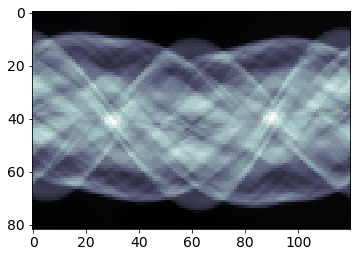

In [4]:
plt.figure()
plt.imshow(b, cmap = 'bone')

### Solution using Tikhonov regularization

In [5]:
from scipy.sparse.linalg import aslinearoperator, LinearOperator

l2 = 10.         #Regularization parameter

# simulate measurement error
bk = b.flatten(order = 'F')

Am = aslinearoperator(A)
Atb =  Am.rmatvec(bk)


Ax = lambda x: Am.rmatvec(Am.matvec(x)) + l2*x

In [6]:
from scipy.sparse.linalg import cg

n = A.shape[1]
Aop = LinearOperator((n,n), matvec = Ax)
x, info = cg(Aop, Atb, tol = 1.e-7, maxiter = 100)

## Plot the reconstruction

Text(0.5, 1.0, 'Reconstruction')

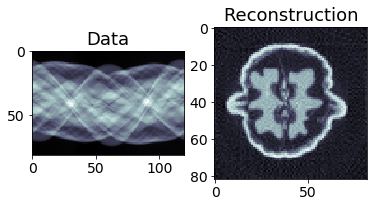

In [15]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(b, cmap = 'bone')
ax1.set_title('Data', fontsize = 18)

N = int(np.sqrt(A.shape[1]))
ax2.imshow(x.reshape(N,N).T, cmap = 'bone')
ax2.set_title('Reconstruction', fontsize = 18)

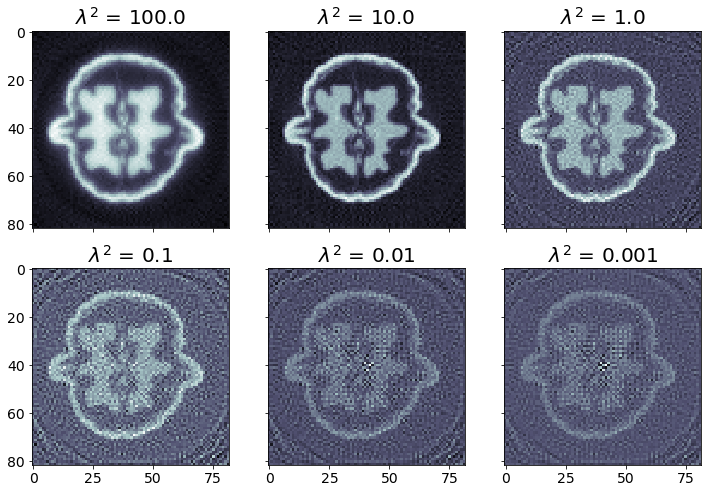

In [8]:
l2lst = [1e2, 1e1,1e0,1e-1,1e-2,1e-3]

from scipy.sparse.linalg import aslinearoperator, LinearOperator, cg
f, axarray = plt.subplots(2,3, sharex = True, sharey = True, figsize = (12,8))
for i, ax in enumerate(axarray.flatten()):
    l2 = l2lst[i]
    
    mat = lambda x: Am.rmatvec(Am.matvec(x)) + l2*x
    H   = LinearOperator(shape = (n,n), matvec = mat)
    
    xk, info = cg(H, Atb, tol = 1.e-7)
    
    ax.imshow( xk.reshape(N,N).T, cmap = 'bone')
    ax.set_title('$\lambda^2$ = ' + str(l2), fontsize = 20)


### Gradient based regularization

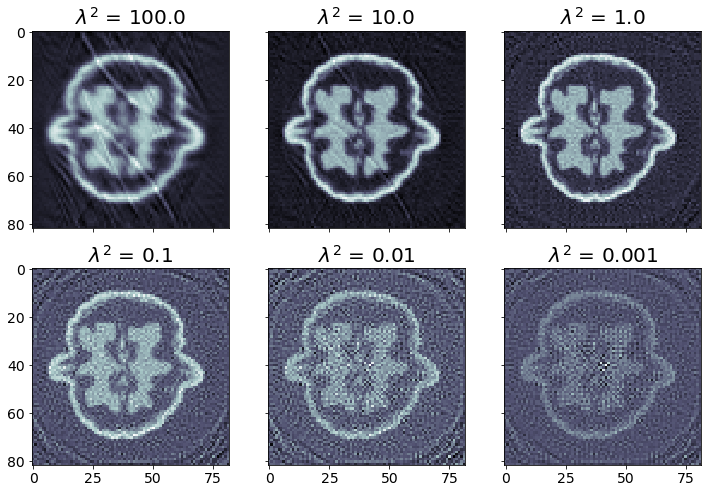

In [9]:
from scipy.sparse import eye, kron, diags
I = eye(N, format = "csr")

data = np.ones((2,N), dtype ='d')
data[0,:] *= -1.0

D = diags(data, np.array([-1,0]), shape=(N+1,N))
L = kron(I,D) + kron(D,I)
Lop = aslinearoperator(L)


l2lst = [1e2,1e1,1e0,1e-1,1e-2,1e-3,1e-4]


f, axarray = plt.subplots(2,3, sharex = True, sharey = True, figsize = (12,8))
for i, ax in enumerate(axarray.flatten()):
    l2 = l2lst[i]
    
    
    mat = lambda x: Am.rmatvec(Am.matvec(x)) + l2*Lop.rmatvec(Lop.matvec(x))
    H   = LinearOperator(shape = (n,n), matvec = mat)
    
    xk, info = cg(H, Atb, tol = 1.e-7)
    
  
    ax.imshow( xk.reshape(N,N).T, cmap = 'bone')
    ax.set_title('$\lambda^2$ = ' + str(l2), fontsize = 20)